# Стилизация изображений с помощью свёрточных сетей

В данной работе будет реализована техника переноса стиля одного изображения на другое с помощью сверточных сетей, описанная в работе [Gatys et al., CVPR 2015](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

Идея заключается в том, чтобы взять два изображения, и получить новое изображение, с содержанием первого и (артистическим) стилем второго.
Метод подразумевает из себя следующее: формулируется функция потерь, которая соответствует содержимому и стилю каждого соответствующего изображения, а затем выполняется градиентный спуск на пикселях самого изображения.

Cетью, используемой в данной работе в качестве экстрактора признаков, является [SqueezeNet](https://arxiv.org/abs/1602.07360) - небольшая модель, обученная на ImageNet. Мы выбрали SqueezeNet из-за ее небольшого размера и эффективности.

## Настройка окружения, загрузка модели

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# импорт необходимых библиотек и объявление констант

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from imageio import imread
from PIL import Image

%matplotlib inline

tf.get_logger().setLevel('ERROR')

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)
NUM_CLASSES = 1000

In [6]:
# вспомогательные функции для обработки изображений

def preprocess_image(img):
    return (img.astype(np.float32) / 255.0 - SQUEEZENET_MEAN) / SQUEEZENET_STD
    

def deprocess_image(img, rescale=False):
    img = img * SQUEEZENET_STD + SQUEEZENET_MEAN
    if rescale:
        vmin, vmax = img.min(), img.max()
        img = (img - vmin) / (vmax - vmin)
    return np.clip(255 * img, 0.0, 255.0).astype(np.uint8)


def load_image(filename, size=None):
    img = imread(filename)
    if size is not None:
        orig_shape = np.array(img.shape[:2])
        min_idx = np.argmin(orig_shape)
        scale_factor = float(size) / orig_shape[min_idx]
        new_shape = (orig_shape * scale_factor).astype(int)
        img = np.array(Image.fromarray(img).resize((new_shape[1],new_shape[0])))
    return img

In [7]:
# реализация архитектуры SqeezeNet

class Fire(tf.keras.Model):
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes,name=None):
        super(Fire, self).__init__(name='%s/fire'%name)
        self.inplanes = inplanes
        self.squeeze = tf.keras.layers.Conv2D(squeeze_planes, input_shape=(inplanes,), kernel_size=1, strides=(1,1), padding="VALID", activation='relu',name='squeeze')
        self.expand1x1 = tf.keras.layers.Conv2D(expand1x1_planes, kernel_size=1, padding="VALID", strides=(1,1), activation='relu',name='e11')
        self.expand3x3 = tf.keras.layers.Conv2D(expand3x3_planes, kernel_size=3, padding="SAME", strides=(1,1), activation='relu',name='e33')

    def call(self, x):
        x = self.squeeze(x)
        return tf.concat([
            self.expand1x1(x),
            self.expand3x3(x)
        ], axis=3)


class SqueezeNet(tf.keras.Model):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes

        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2,2), padding="VALID", activation='relu', input_shape=(224, 224, 3), name='features/layer0'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, name='features/layer2'),
            Fire(64, 16, 64, 64, name='features/layer3'),
            Fire(128, 16, 64, 64, name='features/layer4'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, name='features/layer5'),
            Fire(128, 32, 128, 128, name='features/layer6'),
            Fire(256, 32, 128, 128, name='features/layer7'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, name='features/layer8'),
            Fire(256, 48, 192, 192, name='features/layer9'),
            Fire(384, 48, 192, 192, name='features/layer10'),
            Fire(384, 64, 256, 256, name='features/layer11'),
            Fire(512, 64, 256, 256, name='features/layer12'),
            tf.keras.layers.Conv2D(self.num_classes, kernel_size=1, padding="VALID",  activation='relu', name='classifier/layer1'),
            tf.keras.layers.AveragePooling2D(pool_size=13, strides=13, padding="VALID", name='classifier/layer3')
            ])

    def call(self, x, save_path=None):
        x = self.net(x)
        scores = tf.reshape(x, (-1, self.num_classes))
        return scores

Далее, чтобы использовать SqueezeNet, нужно скачать веса.

In [8]:
# подходит для Unix систем (в том числе Google Colab)

!wget "http://cs231n.stanford.edu/squeezenet_tf2.zip"
!unzip squeezenet_tf2.zip
!rm squeezenet_tf2.zip

--2020-12-15 20:13:23--  http://cs231n.stanford.edu/squeezenet_tf2.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4592284 (4.4M) [application/zip]
Saving to: ‘squeezenet_tf2.zip’

squeezenet_tf2.zip  100%[===================>]   4.38M  9.33MB/s    in 0.5s    

2020-12-15 20:13:24 (9.33 MB/s) - ‘squeezenet_tf2.zip’ saved [4592284/4592284]

Archive:  squeezenet_tf2.zip
  inflating: squeezenet.ckpt.data-00000-of-00001  
  inflating: squeezenet.ckpt.index   


In [9]:
model=SqueezeNet()
model.load_weights('squeezenet.ckpt')
model.trainable=False

## Вычисление потерь

Для того чтобы сгенерировать изображение, которое отражает содержание одного изображения и стиль другого, нужно пенализировать отклонения от содержания изображения-контента и отклонения от стиля изображения-стиля. Затем можно  использовать эту гибридную функцию потерь для выполнения градиентного спуска **не по параметрам** модели, а **по значениям пикселей** исходного изображения.

Теперь вычислим три компонента нашей функции потерь. Функция потерь представляет собой взвешенную сумму трех членов: потеря контента + потеря стиля + потеря общего отклонения.

Все нижеперечисленные формулы взяты из работы [Gatys et al., CVPR 2015](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

### Потеря контента (содержимого)

Потеря контента определяется как:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$,

где
- $w_c$ - вес члена потери контета в итоговой функции потерь
- $F^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$ - карта признаков текущего изображения
- $P^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$ - карта признаков исходного изображения

In [10]:
def content_loss(content_weight, content_current, content_original):
    return content_weight * tf.reduce_sum(tf.math.squared_difference(content_current, content_original))

# функиця, извлекающая признаки для каждого слоя изображения
def extract_features(x, cnn):
    features = []
    prev_feat = x
    for i, layer in enumerate(cnn.net.layers[:-2]):
        next_feat = layer(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

### Потеря стиля

1. Подсчет матрицы ковариации $G$ между значениями каждого канала карты признаков:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

2. Тогда потеря стиля определяется как Евклидово расстояние между двумя Gram матрицами:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2, $$ 
где $A$ - матрица ковариации исходного изображения.

In [11]:
# вычисление Gram матрицы из признаков

def gram_matrix(features, normalize=True):  
    _, H, W, C = tf.shape(features)
    features = tf.reshape(features, [H * W, C])
    gram = tf.matmul(tf.transpose(features), features)
    if normalize:
        gram /= tf.cast(H * W * C, dtype=tf.float32)
    return gram

In [12]:
# вычисление потерь стиля для набора слоев

def style_loss(feats, style_layers, style_targets, style_weights):
    style_loss = 0
    for i in range(len(style_layers)):
        G = gram_matrix(feats[style_layers[i]])
        style_loss += style_weights[i] * tf.reduce_sum(tf.math.squared_difference(G, style_targets[i]))
    return style_loss

### Потеря общего отклонения

Регуляризация пространственной гладкости, с целью уменьшить шум на выходе изображения:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

In [13]:
def tv_loss(img, tv_weight):
    _, H, W, C = tf.shape(img)
    diff_vertical = img[:,:H-1,:,:] - img[:,1:H,:,:]
    diff_horizontal = img[:,:,:W-1,:] - img[:,:,1:W,:]
    return tv_weight * (tf.reduce_sum(diff_vertical**2) + tf.reduce_sum(diff_horizontal**2))

## Перенос стиля
Функция ниже объединяет все функции потерь, которые были описаны ранее, и оптимизирует изображение, которое минимизирует общие потери.

In [14]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, max_iter=200, init_random = False):
    """
    параметры:
    - image_size: размер наименьшего измерения изображения (используется для потери контента и сгенерированного изображения)
    - style_size: размер наименьшего измерения изображения, являющегося источником стиля
    - content_layer: слой, который будет использоваться для потери контента
    - content_weight: вес члена потери контета в итоговой функции потерь
    - style_layers: список слоёв, которые будут использоваться для потери стиля
    - style_weights: список весов для каждого слоя в потере стиля
    - tv_weight: вес члена потери общего отклонения в итоговой функции потерь
    - init_random: нужно ли инициализировать начальное изображение как случайный шум
    """
    # извлечение признаков из изображения-контента
    content_img = preprocess_image(load_image(content_image, size=image_size))
    feats = extract_features(content_img[None], model)
    content_target = feats[content_layer]
    
    # извлечение признаков из изображения-стиля
    style_img = preprocess_image(load_image(style_image, size=style_size))
    s_feats = extract_features(style_img[None], model)
    style_targets = []
    # список Gram матриц
    for idx in style_layers:
        style_targets.append(gram_matrix(s_feats[idx]))
    
    # гиперпараметры оптимизации
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    
    step = tf.Variable(0, trainable=False)
    boundaries = [decay_lr_at]
    values = [initial_lr, decayed_lr]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

    learning_rate = learning_rate_fn(step)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess_image(content_img))
    axarr[1].imshow(deprocess_image(style_img))
    plt.show()
    plt.figure()
    
    # инициализация генерируемого изображения
    if init_random:
        initializer = tf.random_uniform_initializer(0, 1)
        img = initializer(shape=content_img[None].shape)
        img_var = tf.Variable(img)
        print("Intializing randomly.")
    else:
        img_var = tf.Variable(content_img[None])
        print("Initializing with content image.")
        
    for t in range(max_iter):
        with tf.GradientTape() as tape:
            tape.watch(img_var)
            feats = extract_features(img_var, model)
            # вычисление потерь
            c_loss = content_loss(content_weight, feats[content_layer], content_target)
            s_loss = style_loss(feats, style_layers, style_targets, style_weights)
            t_loss = tv_loss(img_var, tv_weight)
            loss = c_loss + s_loss + t_loss
        # вычисление градиента
        grad = tape.gradient(loss, img_var)
        optimizer.apply_gradients([(grad, img_var)])
        
        img_var.assign(tf.clip_by_value(img_var, -1.5, 1.5))
            
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.imshow(deprocess_image(img_var[0].numpy(), rescale=True))
            plt.axis('off')
            plt.show()
    print('Iteration {}'.format(t))    
    plt.imshow(deprocess_image(img_var[0].numpy(), rescale=True))
    plt.axis('off')
    plt.show()

Наконец, протестируем стилизацию изображений.

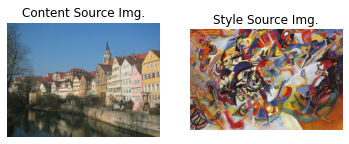

Initializing with content image.
Iteration 0


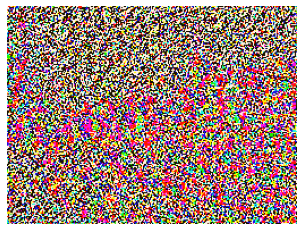

Iteration 100


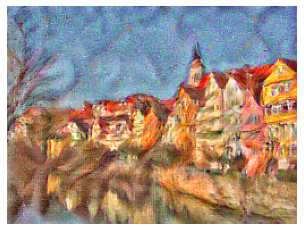

Iteration 199


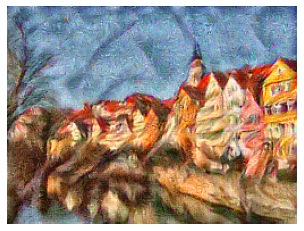

In [15]:
FOLDERNAME = '/content/drive/My Drive/Курсовая_Артемьева_Палатова_БПМ171'

# Composition VII + Tubingen
params1 = {
    'content_image' : '%s/styles/tubingen.jpg' % (FOLDERNAME),
    'style_image' : '%s/styles/composition_vii.jpg' % (FOLDERNAME),
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 2,
    'content_weight' : 5e-2, 
    'style_layers' : (0, 3, 5, 6),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

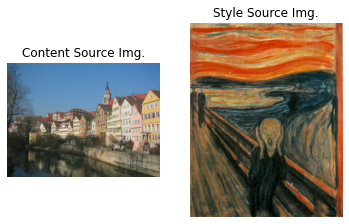

Initializing with content image.
Iteration 0


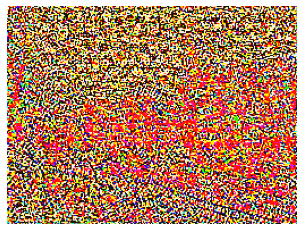

Iteration 100


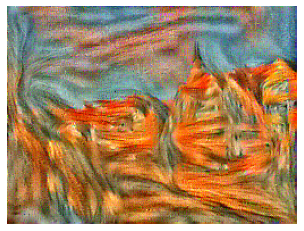

Iteration 199


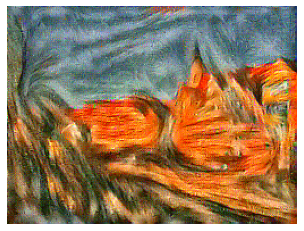

In [16]:
# Scream + Tubingen
params2 = {
    'content_image':'%s/styles/tubingen.jpg' % (FOLDERNAME),
    'style_image':'%s/styles/the_scream.jpg' % (FOLDERNAME),
    'image_size':192,
    'style_size':224,
    'content_layer':2,
    'content_weight':3e-2,
    'style_layers':[0, 3, 5, 6],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

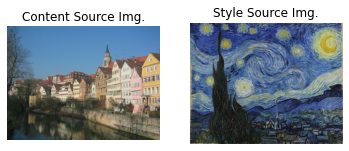

Initializing with content image.
Iteration 0


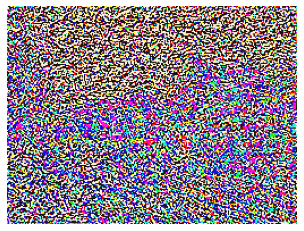

Iteration 100


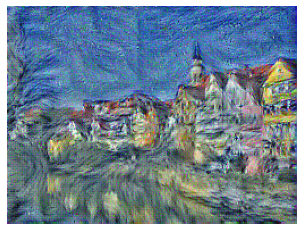

Iteration 199


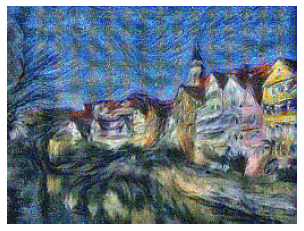

In [18]:
# Starry Night + Tubingen
params3 = {
    'content_image' : '%s/styles/tubingen.jpg' % (FOLDERNAME),
    'style_image' : '%s/styles/starry_night.jpg' % (FOLDERNAME),
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 2,
    'content_weight' : 6e-2,
    'style_layers' : [0, 3, 5, 6],
    'style_weights' : [300000, 1200, 10, 2],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

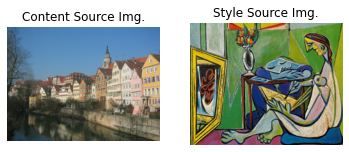

Initializing with content image.
Iteration 0


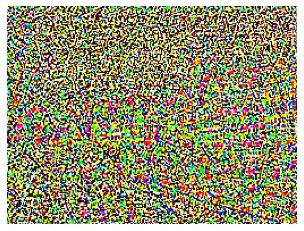

Iteration 100


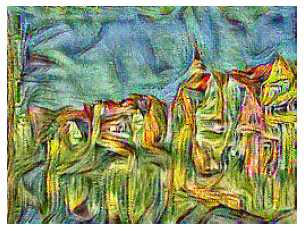

Iteration 199


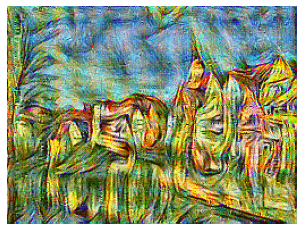

In [19]:
# Muse + Tubingen
params4 = {
    'content_image' : '%s/styles/tubingen.jpg' % (FOLDERNAME),
    'style_image' : '%s/styles/muse.jpg' % (FOLDERNAME),
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 2,
    'content_weight' : 6e-2,
    'style_layers' : [0, 3, 5, 6],
    'style_weights' : [200000, 800, 12, 2],
    'tv_weight' : 2e-2
}

style_transfer(**params4)